<a href="https://colab.research.google.com/github/EmmanuelLwele/Parametric-Representation-of-3D-Propeller-Blade-Geometry/blob/main/Question5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESGI 2025 AALBORG

## PROBLEM 2 Parametric Representation of 3D Propeller Blade Geometry

### QUESTION #1

#### Description of the camber as a reversible transformation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from tqdm import tqdm

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

##### Going forwards

In [ ]:
#blade parameters

mm = 0.25             # max blade half-width
pp = 0.5              # x-coordinate of point in the camber line giving the max blade half-width
rr = 0.12              # leading edge radius
tt = np.sqrt(rr)/1.1

In [ ]:
# y-coordinate of points in the camber line as a function of the x-coordinate

def yycc(x,m,p):

    out = m *(2*p*x -x**2)/p**2
    if (x > p):
        out = m*(1 -2*p +2*p*x-x**2)/(1-p)**2
    return out


# derivative of the funtion giving the y-coord

def dyycc(x,m,p):
    # Use np.where for vectorized conditional logic
    out = np.where(x <= p, m * (2*p - 2*x) / p**2, m * (2*p - 2*x) / (1-p)**2)
    return out


# half-width as a function of the x-coord of the corresponding point in the camber line

def width(x,t):
  out = t *(0.2969*np.sqrt(x)-0.1260 *x -0.3516 * x**2 + 0.2843 * x**3 -0.10150 * x**4)/0.20
  return out


# angle between tangent to camber line and horizontal axis

def varphi(x,m,p):
  out = np.arctan2(dyycc(x,m,p),1)
  return out


# points in the upper curve (suction side)

def xxuu(x,m,p,t):
  out = x - width(x,t) * np.sin(varphi(x,m,p))
  return out

def yyuu(x,m,p,t):
  out = yycc(x,m,p) + width(x,t) * np.cos(varphi(x,m,p))
  return out


# points in the lower curve (pressure side)

def xxll(x,m,p,t):
  out = x + width(x,t) * np.sin(varphi(x,m,p))
  return out

def yyll(x,m,p,t):
  out = yycc(x,m,p) - width(x,t) * np.cos(varphi(x,m,p))
  return out


In [ ]:
npts = 1000
xx = np.linspace(0,1,npts)
YC = np.array([yycc(u,mm,pp) for u in xx])

In [ ]:
%%skip

plt.axis('equal')
plt.title(f'Camber line for m={mm}, p={pp} and r={rr}')
plt.plot(xx,YC)
#plt.axis('off')
plt.show()

In [ ]:
%%skip

half_width = np.array([width(u,tt) for u in xx])

plt.axis('equal')
plt.title(f'Half-width function for m={mm}, p={pp} and r={rr}')
plt.plot(xx,half_width)

In [ ]:
%%skip

angles = np.array([varphi(u,mm,pp) for u in xx])

plt.axis('equal')
plt.title(f'Varphi for m={mm}, p={pp} and r={rr}')
plt.plot(xx,angles)

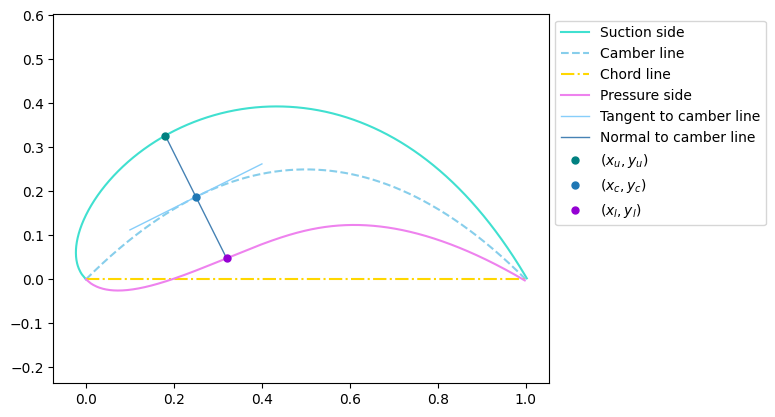

In [ ]:
XU = np.array([xxuu(u,mm,pp,tt) for u in xx])
YU = np.array([yyuu(u,mm,pp,tt) for u in xx])
XL = np.array([xxll(u,mm,pp,tt) for u in xx])
YL = np.array([yyll(u,mm,pp,tt) for u in xx])

x_c = 0.25

plt.axis('equal')
#plt.title(f'Blade profile for m={mm}, p={pp} and r={rr}')
# lines
plt.plot(XU,YU, color='turquoise',label='Suction side')
plt.plot(xx,YC, color='skyblue',linestyle='dashed',label='Camber line')
plt.plot([0,1],[0,0], color='gold',linestyle='dashdot',label='Chord line')
plt.plot(XL,YL, color='violet',label='Pressure side')
# tangent
plt.plot([x_c-0.15, x_c+0.15], [dyycc(x_c, mm, pp)*(-0.15)+yycc(x_c, mm, pp), dyycc(x_c, mm, pp)*(0.15)+yycc(x_c, mm, pp)],
         color='lightskyblue', linewidth=1, label='Tangent to camber line')
# normal
plt.plot([xxuu(x_c,mm,pp,tt), xxll(x_c,mm,pp,tt)], [yyuu(x_c,mm,pp,tt), yyll(x_c,mm,pp,tt)],
         color='steelblue', linewidth=1, label='Normal to camber line')
# points
plt.plot(xxuu(x_c,mm,pp,tt), yyuu(x_c,mm,pp,tt), 'o', markersize=5, color='teal', label='$(x_u,y_u)$')  # plot in upper curve
plt.plot(x_c, yycc(x_c,mm,pp), 'o', markersize=5, label='$(x_c,y_c)$')  # plot in camber line
plt.plot(xxll(x_c,mm,pp,tt), yyll(x_c,mm,pp,tt), 'o', markersize=5, color='darkviolet', label='$(x_l,y_l)$')  # plot in lower curve
plt.legend(bbox_to_anchor=(1.45, 1))
plt.show()

##### Going backwards

In [ ]:
from scipy.optimize import root_scalar

In [ ]:
# the function to compute alpha and beta for given x-coordinate

def find_alpha_and_beta(x, m, p, t, x0_guess=0.5, tol=1e-6):
    """
    Find: alpha such that xxuu(alpha, m, p, t) = x
    and beta such that xxll(beta, m, p, t) = x.
    """
    targets = [x]
    solutionsu = []
    solutionsl = []

    for value in targets:
        # functions whose root we want:
        # f(x) = xxuu(x) - value = 0
        fu = lambda x: xxuu(x, m, p, t) - value
        # g(x) = xxcc(x) - value = 0
        fl = lambda x: xxll(x, m, p, t) - value

        # initial guess for the root
        x0 = x0_guess

        # we try to bracket the root around [0,1]
        try:
            sol = root_scalar(fu, bracket=(0.0, 1.0), method="bisect", xtol=tol)
            if sol.converged:
                solutionsu.append(sol.root)
            else:
                solutionsu.append(np.nan)
        except ValueError:
            # if no sign change in [0,1]
            solutionsu.append(np.nan)

        # initial guess for the root
        x0 = x0_guess

        # we try to bracket the root around [0,1]
        try:
            sol = root_scalar(fl, bracket=(0.0, 1.0), method="bisect", xtol=tol)
            if sol.converged:
                solutionsl.append(sol.root)
            else:
                solutionsl.append(np.nan)
        except ValueError:
            # if no sign change in [0,1]
            solutionsl.append(np.nan)

    return np.array(solutionsu), np.array(solutionsl), targets


In [ ]:
common_x = 0.2

alpha, beta, y_c = find_alpha_and_beta(common_x,mm, pp, tt)

print(alpha)
print(beta)
print(y_c)

[0.26637936]
[0.12072849]
[0.2]


In [ ]:
# check outputs

print(xxuu(alpha,mm,pp,tt))
print(yyuu(alpha,mm,pp,tt))
print(xxll(beta,mm,pp,tt))
print(yyll(beta,mm,pp,tt))

[0.20000083]
[0.33748618]
[0.19999974]
[0.00164851]


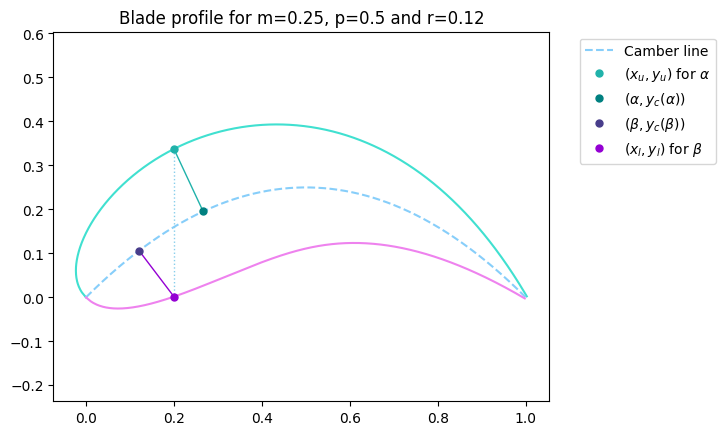

In [ ]:
common_x = 0.2
alpha, beta, y_c = find_alpha_and_beta(common_x,mm, pp, tt)
alpha_for_x = alpha[0]
beta_for_x = beta[0]

plt.axis('equal')
plt.title(f'Blade profile for m={mm}, p={pp} and r={rr}')
# curves
plt.plot(XU,YU, color='turquoise')
plt.plot(xx,YC, color='lightskyblue', linestyle='dashed',label='Camber line')
plt.plot(XL,YL, color='violet')
# line segments
plt.plot([common_x, alpha_for_x], [yyuu(alpha_for_x,mm,pp,tt), yycc(alpha_for_x,mm,pp)],
         color='lightseagreen', linewidth=1)
plt.plot([common_x, beta_for_x], [yyll(beta_for_x,mm,pp,tt), yycc(beta_for_x,mm,pp)],
         color='darkviolet', linewidth=1)
plt.plot([common_x, common_x], [yyuu(alpha_for_x,mm,pp,tt), yyll(beta_for_x,mm,pp,tt)],
         color='skyblue', linestyle='dotted', linewidth=1)
# points
plt.plot(common_x, yyuu(alpha_for_x,mm,pp,tt), 'o', markersize=5, color='lightseagreen', label='$(x_u,y_u)$ for $\\alpha$')  # point in upper curve
plt.plot(alpha_for_x, yycc(alpha_for_x,mm,pp), 'o', markersize=5, color='teal', label='$(\\alpha,y_c(\\alpha))$')  # alpha-point in camber line
plt.plot(beta_for_x, yycc(beta_for_x,mm,pp), 'o', markersize=5, color='darkslateblue', label='$(\\beta,y_c(\\beta))$')  # beta-point in camber line
plt.plot(common_x, yyll(beta_for_x,mm,pp, tt), 'o', markersize=5, color='darkviolet', label='$(x_l,y_l)$ for $\\beta$')  # point in lower curve

plt.legend(bbox_to_anchor=(1.35, 1))
plt.show()

### QUESTION #5

#### Inclusion the parametric ASE in the 2D parametric profile section foil geometry

In [ ]:
# function defining the cut on the 2D profile

def cut(x, theta, x_TE, y_TE):
  out = np.tan(theta) * (x-x_TE) + y_TE

  return out

In [ ]:
# TE is the point on the camber line where the cut happens

x_TE = 0.9                                                  # x-coord of the TE point
y_TE = yycc(x_TE, mm, pp)                                   # y-coord of the TE point

alpha, beta, y_c = find_alpha_and_beta(x_TE, mm, pp, tt)
beta_for_x_TE = beta[0]                                     # value to get y-coord in the pressure side


In [ ]:
theta = -0.8

# get the intersection point on the suction side

# f(x) = yyuu(x) - cut(x) = 0
ff = lambda x: yyuu(x, mm, pp, tt) - cut(xxuu(x, mm, pp, tt), theta, x_TE, y_TE)

# initial guess for the root
x0 = 0.7

# we try to bracket the root around [0,1]
sol = root_scalar(ff, bracket=(0.0, 1.0), method="bisect", xtol=1e-6)
print(sol.root)

0.624140739440918


/tmp/ipython-input-1758997916.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(x_c, yycc(x_c,mm,pp), 'o', markersize=5, marker='s', label='$Q=(x_c,y_c)$')  # plot in camber line
/tmp/ipython-input-1758997916.py:27: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(xxll(x_c,mm,pp,tt), yyll(x_c,mm,pp,tt), 'o', markersize=5, marker='D', color='darkviolet', label='$R=(x_l,y_l)$')  # plot in lower curve


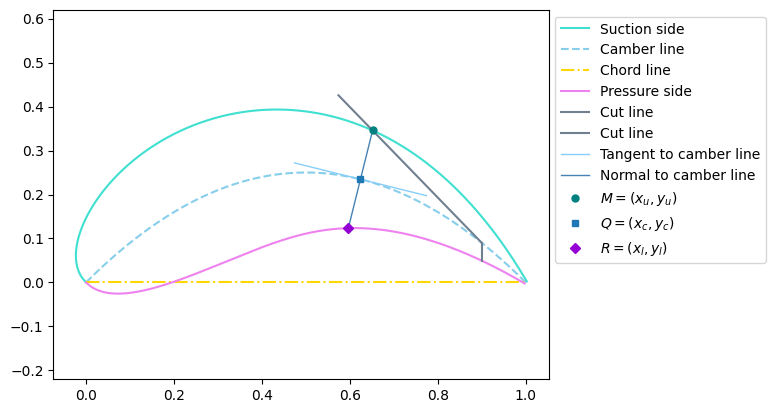

In [ ]:
x_c = sol.root # x-coord of the intersection point

plt.axis('equal')
#plt.title(f'Blade profile for m={mm}, p={pp} and r={rr}')

# lines
plt.plot(XU,YU, color='turquoise',label='Suction side')
plt.plot(xx,YC, color='skyblue',linestyle='dashed',label='Camber line')
plt.plot([0,1],[0,0], color='gold',linestyle='dashdot',label='Chord line')
plt.plot(XL,YL, color='violet',label='Pressure side')

# cut lines
plt.plot([x_TE, x_TE], [yyll(beta_for_x_TE, mm, pp, tt), y_TE], color='slategrey',label='Cut line')
plt.plot([x_c-0.05, x_TE], [cut(x_c-0.05, theta, x_TE, y_TE), cut(x_TE, theta, x_TE, y_TE)], color='slategrey',label='Cut line')

# tangent
plt.plot([x_c-0.15, x_c+0.15], [dyycc(x_c, mm, pp)*(-0.15)+yycc(x_c, mm, pp), dyycc(x_c, mm, pp)*(0.15)+yycc(x_c, mm, pp)],
         color='lightskyblue', linewidth=1, label='Tangent to camber line')

# normal
plt.plot([xxuu(x_c,mm,pp,tt), xxll(x_c,mm,pp,tt)], [yyuu(x_c,mm,pp,tt), yyll(x_c,mm,pp,tt)],
         color='steelblue', linewidth=1, label='Normal to camber line')

# points
plt.plot(xxuu(x_c,mm,pp,tt), yyuu(x_c,mm,pp,tt), 'o', markersize=5, color='teal', label='$M=(x_u,y_u)$')  # plot in upper curve
plt.plot(x_c, yycc(x_c,mm,pp), 'o', markersize=5, marker='s', label='$Q=(x_c,y_c)$')  # plot in camber line
plt.plot(xxll(x_c,mm,pp,tt), yyll(x_c,mm,pp,tt), 'o', markersize=5, marker='D', color='darkviolet', label='$R=(x_l,y_l)$')  # plot in lower curve

plt.legend(bbox_to_anchor=(1.45, 1))
plt.show()